* Generate truth and backgrounds:

The truth is the same as in the 3dvar, no need to generate again!


In [ ]:
cp -r /home/jedi/EDU/qg3Dvar/output/truth/ /home/jedi/EDU/qg4Dvar/output
ls /home/jedi/EDU/qg4Dvar/output/truth

Generating the perturbed backgrounds 

In [ ]:
cd /home/jedi/EDU
./build/bin/qg_gen_ens_pert_B.x ./qg4Dvar/yamls/genenspert_B_default.yaml

Create plots for the background error

In [ ]:
cd /home/jedi/EDU/plots_scripts
python ./plot.py qg fields \
        /home/jedi/EDU/qg4Dvar/output/exp_default/bg/bkgd.fc.2009-12-30T00\:00\:00Z.PT0S.nc \
        /home/jedi/EDU/qg4Dvar/output/truth/truth.fc.2009-12-15T00\:00\:00Z.P15D.nc \
        --output /home/jedi/EDU/qg4Dvar/output/exp_default/plots/bkgd_error --title "background error"
display < /home/jedi/EDU/qg4Dvar/output/exp_default/plots/bkgd_error_x_diff.jpg

Generate one obs at the beginning:

In [ ]:
cd /home/jedi/EDU
./build/bin/qg_hofx.x ./qg4Dvar/yamls/makeobs4d_oneobs_begin.yaml

In [ ]:
cd /home/jedi/EDU/plots_scripts
python ./plot.py qg obs /home/jedi/EDU/qg4Dvar/output/exp_default/obs/truth.1obs.begin.nc \
        --output /home/jedi/EDU/qg4Dvar/output/exp_default/plots/qg_oneobs_begin
cat /home/jedi/EDU/qg4Dvar/output/exp_default/plots/qg_oneobs_begin.txt

Run 4dvar:

In [ ]:
cd /home/jedi/EDU
./build/bin/qg_4dvar.x ./qg4Dvar/yamls/4dvar_oneobs_begin.yaml

Look at results:

In [ ]:
cd /home/jedi/EDU/plots_scripts
python ./plot.py qg fields \
        /home/jedi/EDU/qg4Dvar/output/exp_default/da/4dvar.1obs.begin.an.2009-12-30T00\:00\:00Z.nc \
        /home/jedi/EDU/qg4Dvar/output/exp_default/bg/bkgd.fc.2009-12-30T00:00:00Z.PT0S.nc \
        --obsLocations /home/jedi/EDU/qg4Dvar/output/exp_default/obs/4dvar.1obs.begin.nc \
        --plotwind \
        --output /home/jedi/EDU/qg4Dvar/output/exp_default/plots/4dvar_inc_begin --title "Increment: obs at beginning of window"
        display < /home/jedi/EDU/qg4Dvar/output/exp_default/plots/4dvar_inc_begin_x_diff.jpg

In [ ]:
python ./plot.py qg fields \
        /home/jedi/EDU/qg4Dvar/output/exp_default/da/4dvar.1obs.begin.an.2009-12-30T00\:00\:00Z.nc \
        /home/jedi/EDU/qg4Dvar/output/truth/truth.fc.2009-12-15T00\:00\:00Z.P15D.nc \
        --obsLocations /home/jedi/EDU/qg4Dvar/output/exp_default/obs/4dvar.1obs.begin.nc \
        --plotwind \
        --output /home/jedi/EDU/qg4Dvar/output/exp_default/plots/4dvar_an_truth --title "Analysis - truth"
        display < /home/jedi/EDU/qg4Dvar/output/exp_default/plots/4dvar_an_truth_x_diff.jpg

In [ ]:
python ./plot.py qg fields \
        /home/jedi/EDU/qg4Dvar/output/exp_default/bg/bkgd.fc.2009-12-30T00:00:00Z.PT0S.nc \
        /home/jedi/EDU/qg4Dvar/output/truth/truth.fc.2009-12-15T00\:00\:00Z.P15D.nc \
        --obsLocations /home/jedi/EDU/qg4Dvar/output/exp_default/obs/4dvar.1obs.begin.nc \
        --plotwind \
        --output /home/jedi/EDU/qg4Dvar/output/exp_default/plots/4dvar_bg_truth --title "Bg - truth"
        display < /home/jedi/EDU/qg4Dvar/output/exp_default/plots/4dvar_bg_truth_x_diff.jpg

Generate one obs in the middle of the window:

In [ ]:
cd /home/jedi/EDU
./build/bin/qg_hofx.x ./qg4Dvar/yamls/makeobs4d_oneobs_mid.yaml

In [ ]:
cd /home/jedi/EDU
./build/bin/qg_4dvar.x ./qg4Dvar/yamls/4dvar_oneobs_mid.yaml

Plot the results:

In [ ]:
cd /home/jedi/EDU/plots_scripts
python ./plot.py qg fields \
        /home/jedi/EDU/qg4Dvar/output/exp_default/da/4dvar.1obs.mid.an.2009-12-30T00\:00\:00Z.nc \
        /home/jedi/EDU/qg4Dvar/output/exp_default/bg/bkgd.fc.2009-12-30T00:00:00Z.PT0S.nc \
        --obsLocations /home/jedi/EDU/qg4Dvar/output/exp_default/obs/4dvar.1obs.mid.nc \
        --plotwind \
        --output /home/jedi/EDU/qg4Dvar/output/exp_default/plots/4dvar_inc_mid --title "Increment: obs at middle of window"
        display < /home/jedi/EDU/qg4Dvar/output/exp_default/plots/4dvar_inc_mid_x_diff.jpg

In [ ]:
python ./plot.py qg fields \
        /home/jedi/EDU/qg4Dvar/output/exp_default/da/4dvar.1obs.mid.an.2009-12-30T12\:00\:00Z.nc \
        /home/jedi/EDU/qg4Dvar/output/exp_default/bg/bkgd.fc.2009-12-30T00:00:00Z.PT12H.nc \
        --obsLocations /home/jedi/EDU/qg4Dvar/output/exp_default/obs/4dvar.1obs.mid.nc \
        --plotwind \
        --output /home/jedi/EDU/qg4Dvar/output/exp_default/plots/4dvar_inc_mid_mid --title "Increment mid: obs at middle of window"
        display < /home/jedi/EDU/qg4Dvar/output/exp_default/plots/4dvar_inc_mid_mid_x_diff.jpg
        display < /home/jedi/EDU/qg4Dvar/output/exp_default/plots/4dvar_inc_mid_mid_u_diff.jpg

And at the end of the window!


In [ ]:
cd /home/jedi/EDU
./build/bin/qg_hofx.x ./qg4Dvar/yamls/makeobs4d_oneobs_end.yaml
./build/bin/qg_4dvar.x ./qg4Dvar/yamls/4dvar_oneobs_end.yaml

In [136]:
cd /home/jedi/EDU/plots_scripts
python ./plot.py qg fields \
        /home/jedi/EDU/qg4Dvar/output/exp_default/da/4dvar.1obs.end.an.2009-12-30T00\:00\:00Z.nc \
        /home/jedi/EDU/qg4Dvar/output/exp_default/bg/bkgd.fc.2009-12-30T00:00:00Z.PT0S.nc \
        --obsLocations /home/jedi/EDU/qg4Dvar/output/exp_default/obs/4dvar.1obs.end.nc \
        --plotwind \
        --output /home/jedi/EDU/qg4Dvar/output/exp_default/plots/4dvar_inc_end --title "Increment: obs at end of window"
        display < /home/jedi/EDU/qg4Dvar/output/exp_default/plots/4dvar_inc_end_x_diff.jpg

Parameters:
 - model: qg
 - diagnostic: fields
 - filepath: /home/jedi/EDU/qg4Dvar/output/exp_default/da/4dvar.1obs.end.an.2009-12-30T00:00:00Z.nc
 - basefilepath: /home/jedi/EDU/qg4Dvar/output/exp_default/bg/bkgd.fc.2009-12-30T00:00:00Z.PT0S.nc
 - fieldmax: None
 - obsLocations: /home/jedi/EDU/qg4Dvar/output/exp_default/obs/4dvar.1obs.end.nc
 - plotwind: True
 - gif: None
 - output: /home/jedi/EDU/qg4Dvar/output/exp_default/plots/4dvar_inc_end
 - title: Increment: obs at end of window
Run script
['/home/jedi/EDU/qg4Dvar/output/exp_default/da/4dvar.1obs.end.an.2009-12-30T00:00:00Z.nc']
Traceback (most recent call last):
  File "./plot.py", line 116, in <module>
    func(args)
  File "plot/qg_fields.py", line 65, in func
    res = netCDF4.Dataset(args.obsLocations)
  File "src/netCDF4/_netCDF4.pyx", line 2307, in netCDF4._netCDF4.Dataset.__init__
  File "src/netCDF4/_netCDF4.pyx", line 1925, in netCDF4._netCDF4._ensure_nc_success
FileNotFoundError: [Errno 2] No such file or directory: b

: 1

Parameters:
 - model: qg
 - diagnostic: fields
 - filepath: /home/jedi/EDU/qg4Dvar/output/exp_default/bg/bkgd.fc.2009-12-30T00:00:00Z.P1D.nc
 - basefilepath: /home/jedi/EDU/qg4Dvar/output/truth/truth.fc.2009-12-15T00:00:00Z.P16D.nc
 - fieldmax: None
 - obsLocations: None
 - plotwind: False
 - gif: None
 - output: None
 - title: None
Run script
['/home/jedi/EDU/qg4Dvar/output/exp_default/bg/bkgd.fc.2009-12-30T00:00:00Z.P1D.nc']
range: 112662783.77779143
 -> plot produced: bkgd.fc.2009-12-30T00:00:00Z.P1D_x_diff.jpg
range: 0.00031818455565658726
 -> plot produced: bkgd.fc.2009-12-30T00:00:00Z.P1D_q_diff.jpg
range: 84.13166533610222
 -> plot produced: bkgd.fc.2009-12-30T00:00:00Z.P1D_u_diff.jpg
range: 51.922020896770405
 -> plot produced: bkgd.fc.2009-12-30T00:00:00Z.P1D_v_diff.jpg
bash: --output: command not found


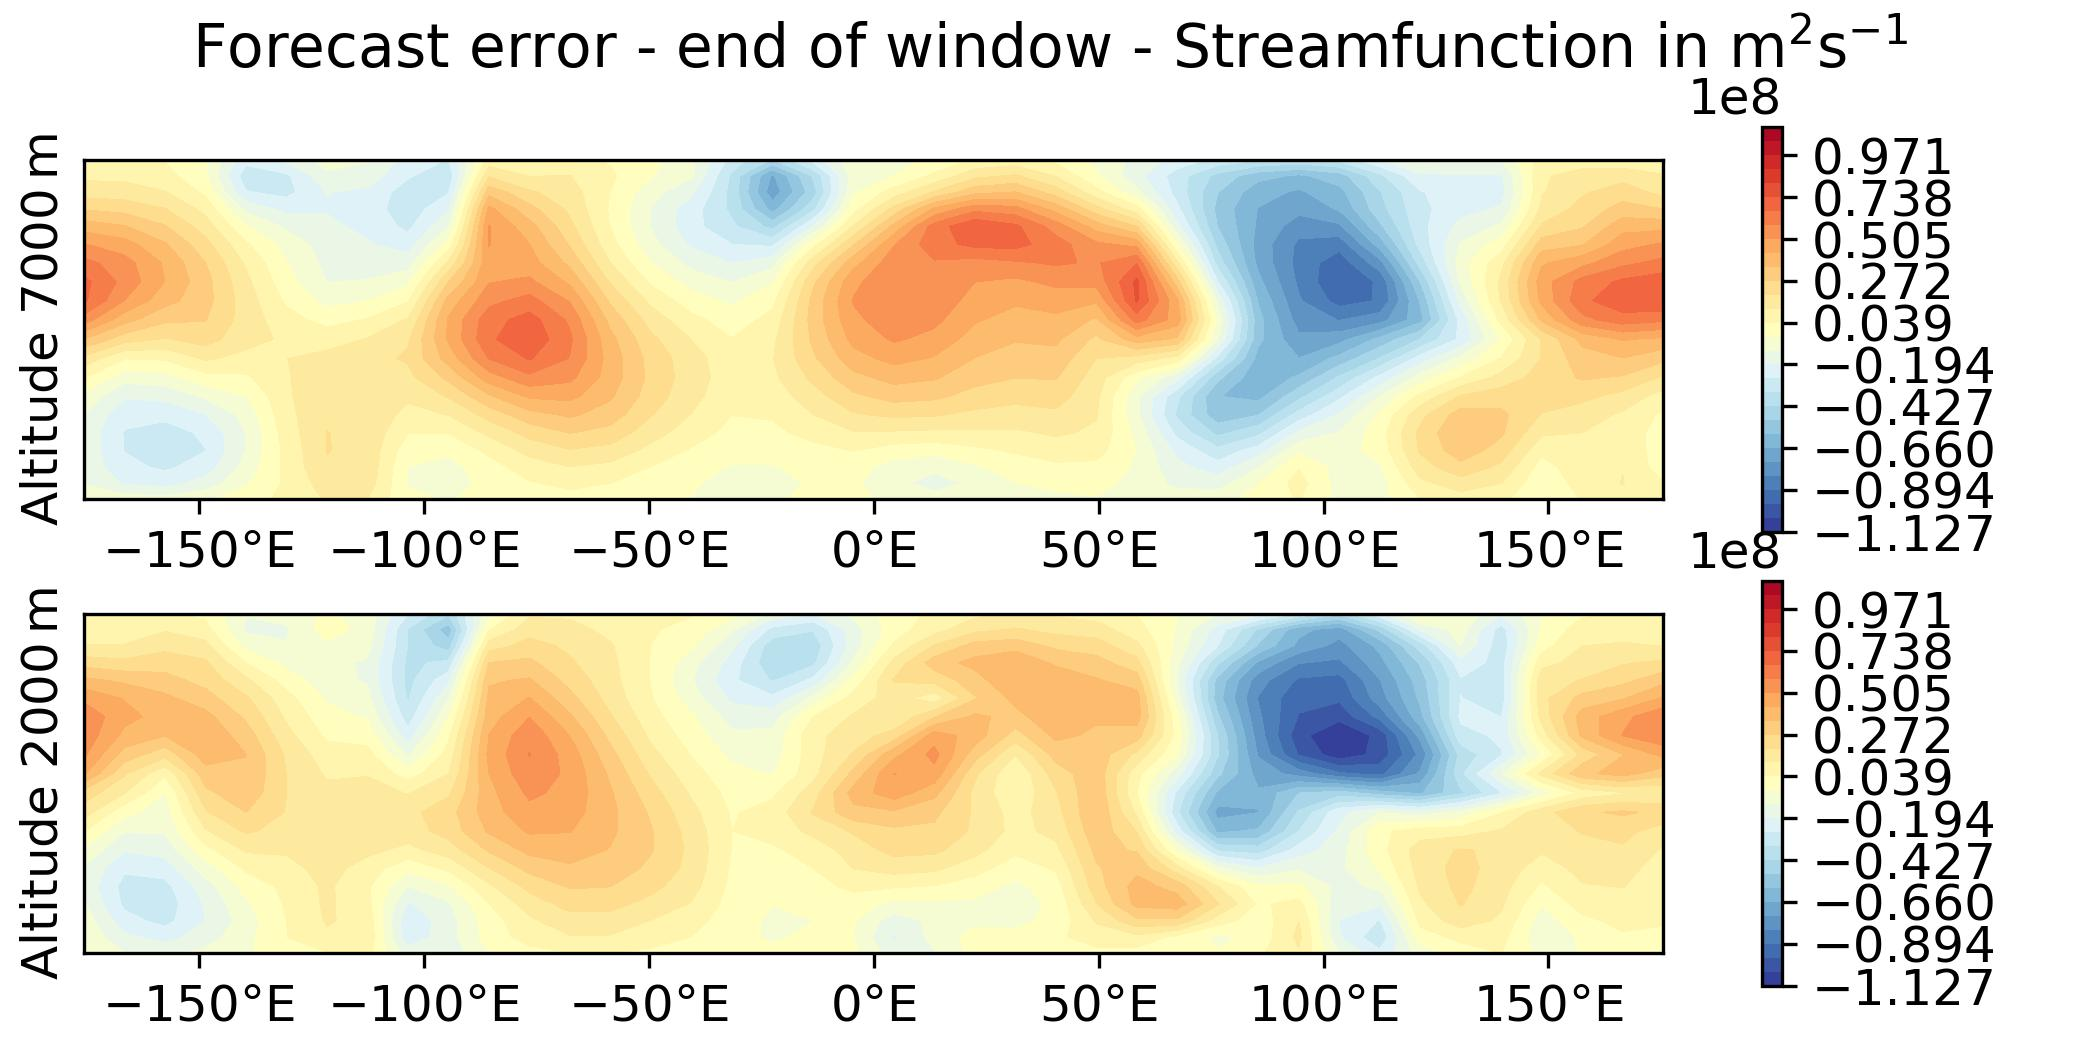

In [153]:
cd /home/jedi/EDU/plots_scripts
python ./plot.py qg fields \
        /home/jedi/EDU/qg4Dvar/output/exp_default/bg/bkgd.fc.2009-12-30T00:00:00Z.P1D.nc \
        /home/jedi/EDU/qg4Dvar/output/truth/truth.fc.2009-12-15T00\:00\:00Z.P16D.nc \
        # --fieldmax 112662784 \
        --output /home/jedi/EDU/qg4Dvar/output/exp_default/plots/4dvar_fc_end --title "Forecast error - end of window"
display < /home/jedi/EDU/qg4Dvar/output/exp_default/plots/4dvar_fc_end_x_diff.jpg

Parameters:
 - model: qg
 - diagnostic: fields
 - filepath: /home/jedi/EDU/qg4Dvar/output/exp_default/da/4dvar.1obs.begin.an.2009-12-31T00:00:00Z.nc
 - basefilepath: /home/jedi/EDU/qg4Dvar/output/truth/truth.fc.2009-12-15T00:00:00Z.P16D.nc
 - fieldmax: 112662784
 - obsLocations: None
 - plotwind: False
 - gif: None
 - output: /home/jedi/EDU/qg4Dvar/output/exp_default/plots/4dvar_an_end
 - title: Analysis error - end of window
Run script
['/home/jedi/EDU/qg4Dvar/output/exp_default/da/4dvar.1obs.begin.an.2009-12-31T00:00:00Z.nc']
range: 112662784
 -> plot produced: /home/jedi/EDU/qg4Dvar/output/exp_default/plots/4dvar_an_end_x_diff.jpg
range: 112662784
 -> plot produced: /home/jedi/EDU/qg4Dvar/output/exp_default/plots/4dvar_an_end_q_diff.jpg
range: 112662784
 -> plot produced: /home/jedi/EDU/qg4Dvar/output/exp_default/plots/4dvar_an_end_u_diff.jpg
range: 112662784
 -> plot produced: /home/jedi/EDU/qg4Dvar/output/exp_default/plots/4dvar_an_end_v_diff.jpg


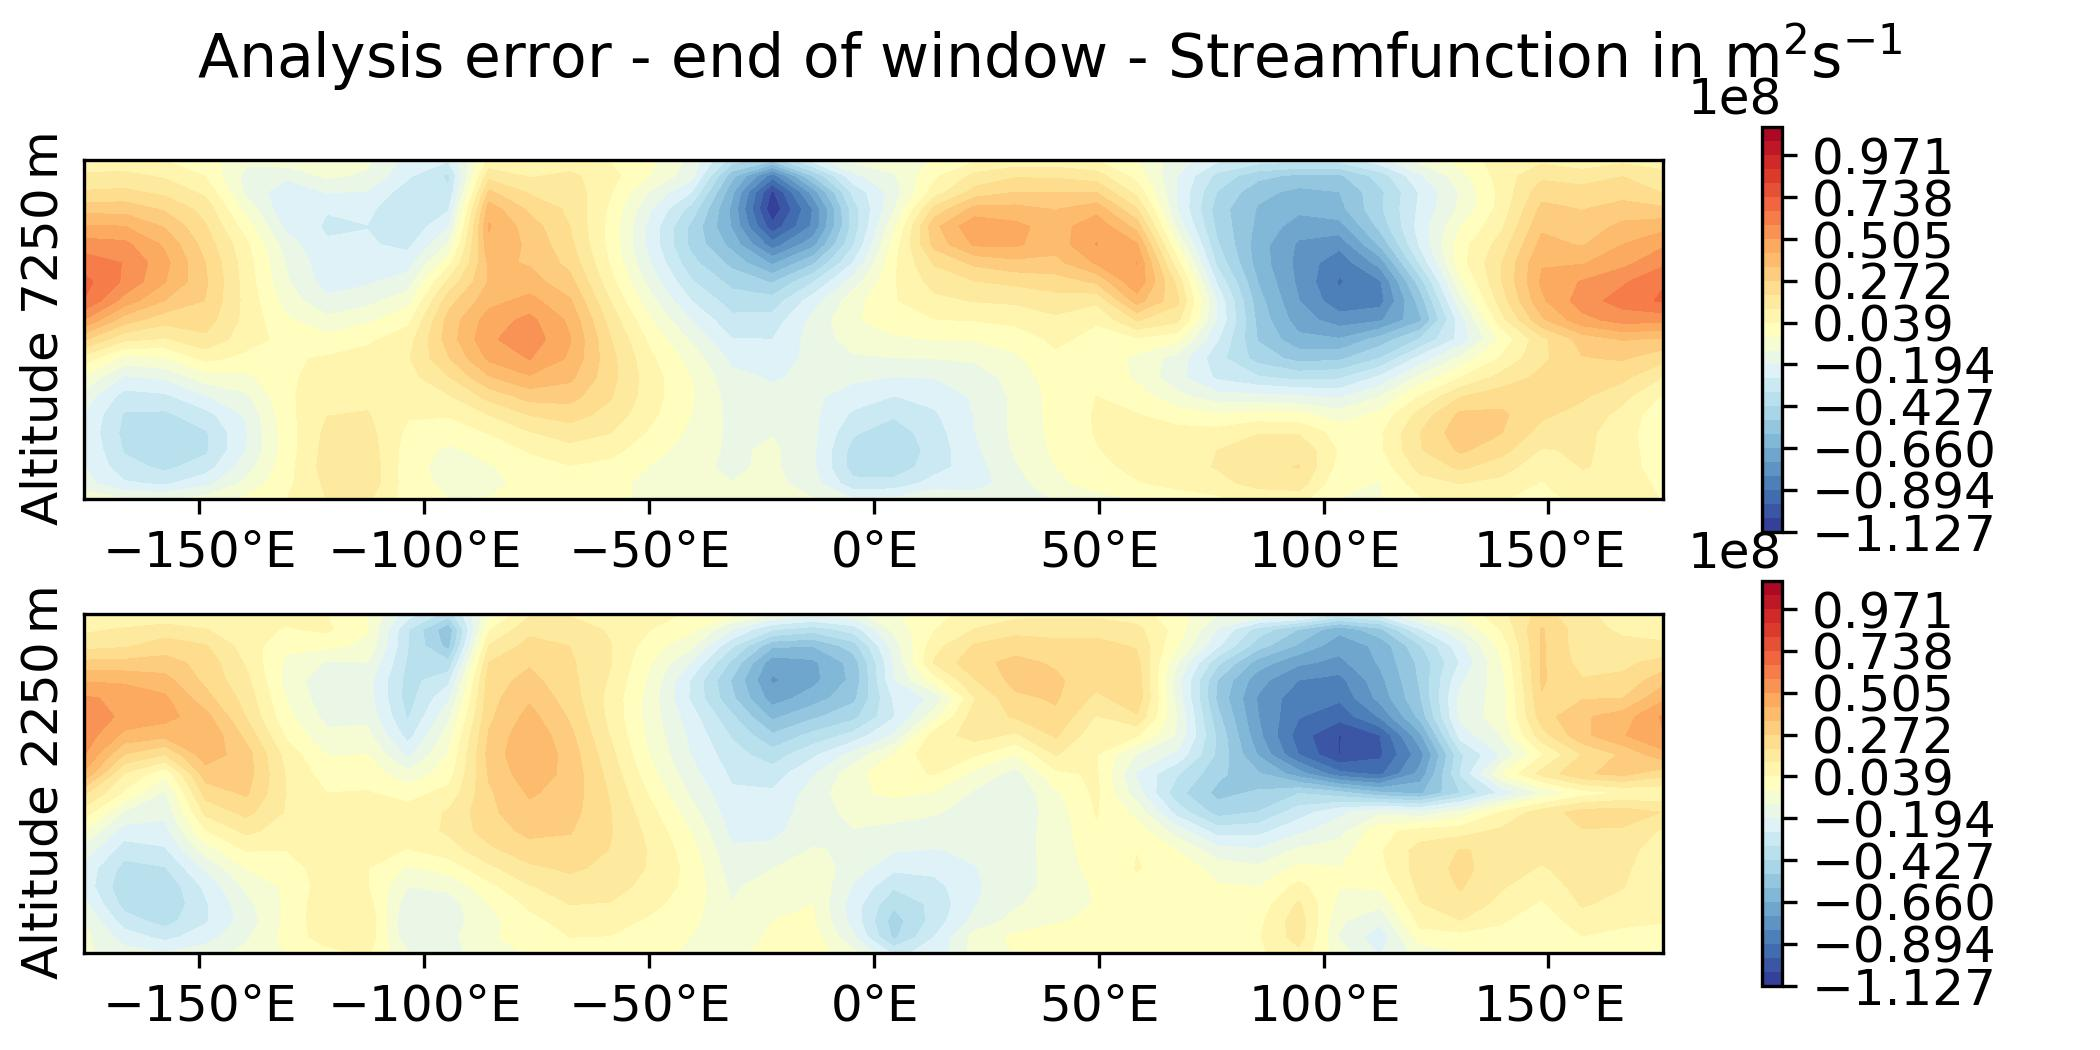

In [150]:
python ./plot.py qg fields \
        /home/jedi/EDU/qg4Dvar/output/exp_default/da/4dvar.1obs.begin.an.2009-12-31T00\:00\:00Z.nc \
        /home/jedi/EDU/qg4Dvar/output/truth/truth.fc.2009-12-15T00\:00\:00Z.P16D.nc \
        --fieldmax 112662784 \
        --output /home/jedi/EDU/qg4Dvar/output/exp_default/plots/4dvar_an_end --title "Analysis error - end of window"
display < /home/jedi/EDU/qg4Dvar/output/exp_default/plots/4dvar_an_end_x_diff.jpg

In [157]:
python ./plot.py qg fields


usage: plot.py qg fields [-h] [--fieldmax FIELDMAX]
                         [--obsLocations OBSLOCATIONS] [--plotwind]
                         [--gif GIF] [--output OUTPUT] [--title TITLE]
                         filepath [basefilepath]
plot.py qg fields: error: the following arguments are required: filepath


: 2